In [1]:
import pennylane as qml
from pennylane import numpy as np
import qemzmsepcV2 as qem

Cost after step     5:  0.2693710
Cost after step    10:  0.1897159
Cost after step    15:  0.1748825
Cost after step    20:  0.1330596
Cost after step    25:  0.0494849
Cost after step    30:  0.0402391
Cost after step    35:  0.0253172
Cost after step    40:  0.0380895
Cost after step    45:  0.0177631
Cost after step    50:  0.0206404
Cost after step    55:  0.0349114
Cost after step    60:  0.0351444
Cost after step    65:  0.0130834
Cost after step    70:  0.1090986
Cost after step    75:  0.0456867
Cost after step    80:  0.0125274
Cost after step    85:  0.0421331
Cost after step    90:  0.0763984
Cost after step    95:  0.0478520
Cost after step   100:  0.0193401
Optimized rotation angles: [[[ 6.12324110e-01  1.55238609e+00  1.09461023e-03]
  [ 9.17347438e-01  1.61350236e+00 -1.28034395e-01]]

 [[ 1.28561303e-01  1.52746946e+00  9.23612699e-01]
  [ 7.49608371e-01  8.31006027e-01  7.31474009e-01]]]


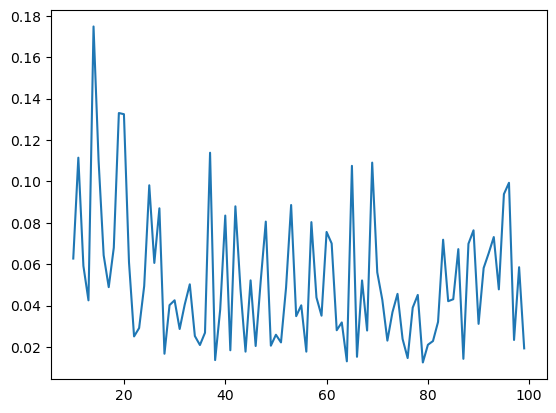

In [2]:
# we introduced noise into the network and trained it without any error mitigation techniques
# to observe the behavior of the Loss function degradation during training.

n_qubits = 2
dev = qml.device('default.mixed', wires=n_qubits)

nqubitschannel = qem.NqubitsChannel(n_qubits)
nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
p = 0.9

qemzmsepc = qem.QEMZMSEPC(n_qubits)

def train_cir_without_qem(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(2))

shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=2)
weights = np.random.random(size=shape)

def cost(x):
    return (qml.QNode(qemzmsepc.noise_circuit, dev)(train_cir_without_qem, x, p=p,
            kraus_matrices_of_a_pauli_channel=nqubitspaulichannel,
            need_gate_noise=True, need_measurement_noise=True) - (-1)) ** 2

opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 100
params = weights
loss = []

for i in range(steps):
    nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
    params = opt.step(cost, params)
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))
    loss.append(cost(params))
print("Optimized rotation angles: {}".format(params))

# When simulating a complex scenario of time-varying noise channels,
# it can be observed that the descent of the Loss function is relatively unstable
# in the absence of error mitigation techniques.

import matplotlib.pyplot as plt
x = [i for i in range(10, 100)]
y = loss[10:]
plt.plot(x, y)
plt.show()

Cost after step     5:  0.4464525
Cost after step    10:  0.0993445
Cost after step    15:  0.0418683
Cost after step    20:  0.0232597
Cost after step    25:  0.0149408
Cost after step    30:  0.0104820
Cost after step    35:  0.0078001
Cost after step    40:  0.0060535
Cost after step    45:  0.0048483
Cost after step    50:  0.0039790
Cost after step    55:  0.0033299
Cost after step    60:  0.0028315
Cost after step    65:  0.0024399
Cost after step    70:  0.0021262
Cost after step    75:  0.0018707
Cost after step    80:  0.0016597
Cost after step    85:  0.0014833
Cost after step    90:  0.0013342
Cost after step    95:  0.0012070
Cost after step   100:  0.0010975
Optimized rotation angles: [[[ 0.32431326  1.35199329  0.21551979]
  [ 0.75221139  2.18067273  0.13250375]]

 [[-0.04932701  0.93752833  0.54434717]
  [ 0.66336584  0.54037661  0.59932581]]]


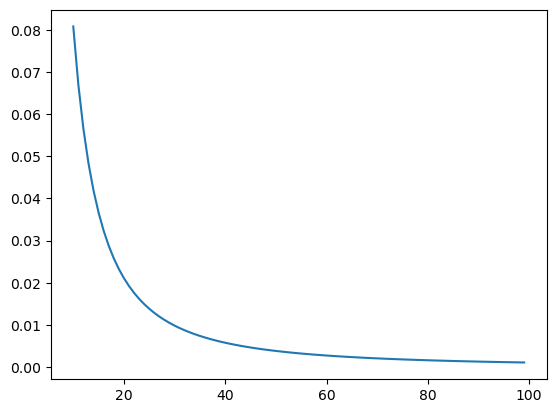

In [3]:
# training with QEM-ZMSEPC method

n_qubits = 2
dev = qml.device('default.mixed', wires=n_qubits)

nqubitschannel = qem.NqubitsChannel(n_qubits)
nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
p = 0.9

qemzmsepc = qem.QEMZMSEPC(n_qubits)

def train_cir_without_qem(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(2))

shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=2)
weights = np.random.random(size=shape)

def cost(x):
    z_miti, _ = qemzmsepc.qemzmsepc(train_cir_without_qem, p, dev, x,
            kraus_matrices_of_a_pauli_channel=nqubitspaulichannel)
    return (z_miti - (-1)) ** 2

opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 100
params = weights
loss = []

for i in range(steps):
    nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
    params = opt.step(cost, params)
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))
    loss.append(cost(params))
print("Optimized rotation angles: {}".format(params))

# When simulating a complex scenario of time-varying noise channels,
# it can be observed that the descent of the Loss function is relatively unstable
# in the absence of error mitigation techniques.

import matplotlib.pyplot as plt
x = [i for i in range(10, 100)]
y = loss[10:]
plt.plot(x, y)
plt.show()